### Leer librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import SimpleRNN
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_squared_error
from keras.utils.vis_utils import plot_model
import datetime
import sys
import os

In [2]:
plt.style.use('ggplot')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imagen informe sectorial

In [ ]:
df = pd.DataFrame(columns=[2019,2020])

In [ ]:
df[2020] = [26586,30599,25519,29231,34411,38963,41162,40506,49903,49248,54878,65224]
df[2019] = [11708,11837,12605,14721,15876,18159,19128,17337,18544,21936,22223,25341]
df.index= (['ENERO', 'FEB', 'MAR', 'ABRIL', 'MAYO', 'JUNIO', 'JULIO', 'AGO', 'SEPT', 'OCT', 'NOV', 'DIC'])

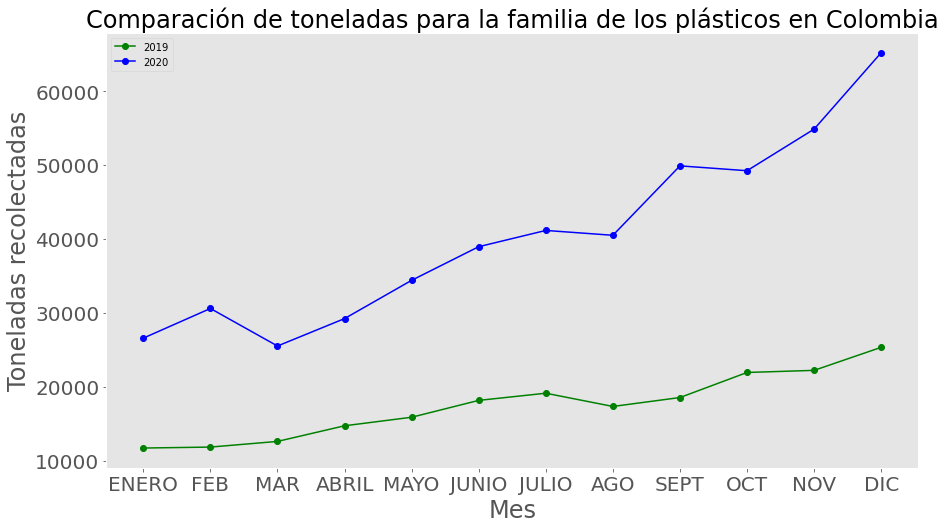

In [ ]:
fig = plt.figure(figsize=(32,8))
ax = fig.add_subplot(1, 2, 1)
#plt.rcParams["figure.figsize"] = [20,9]
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(20)
#plt.rcParams['font.size'] = '20'
ax.plot(df[2019],label='2019',marker='o',color='g');
ax.plot(df[2020],label='2020',marker='o',color='b');
ax.legend();
ax.set_xlabel('Mes',fontsize=24);
ax.set_ylabel('Toneladas recolectadas',fontsize=24);
#ax.title.set_text('Comparative Tons 2019-2020 for the plastics family in Colombia')
plt.title('Comparación de toneladas para la familia de los plásticos en Colombia',fontsize=24)
#ax.set_ylim(ymin=1170000,ymax=1200000)
plt.grid()
plt.show()

# Parámetros y funciones

In [ ]:
#!cp '/content/drive/MyDrive/Proyecto-Residuos-COVID-AMB/Implementacion/Funciones/DataProcessing.py' .
#!cp '/content/drive/MyDrive/Proyecto-Residuos-COVID-AMB/Implementacion/Funciones/DataPrediction.py' .

!cp '/content/drive/MyDrive/Proyecto-Residuos-COVID-AMB/Implementacion/Funciones/Generation_Model.py' .
!cp '/content/drive/MyDrive/Proyecto-Residuos-COVID-AMB/Implementacion/Funciones/Plot_Results.py' .

#!cp '/content/drive/MyDrive/Proyecto-Residuos-COVID-AMB/Implementacion/Funciones/RNN_Functions.py' .
#!cp '/content/drive/MyDrive/Proyecto-Residuos-COVID-AMB/Implementacion/Funciones/LSTM_Functions.py' .
#!cp '/content/drive/MyDrive/Proyecto-Residuos-COVID-AMB/Implementacion/Funciones/GRU_Functions.py' .

In [ ]:
#from DataProcessing import * # preprocesamiento de datos
#from DataPrediction import * # predicciones en base a los datos
from Generation_Model import * # funciones para el modelo de generación de residuos
from Plot_Results import * # funciones para graficar resultados del modelo

#from RNN_Functions import * # funciones para la RNN
#from LSTM_Functions import * # funciones para la LSTM
#from GRU_Functions import * # funciones para la red GRU

# Datos Simulacion Residuos

In [ ]:
# Parámetros de entrada del script
periodo = '2' # Si es 1 la predicción empieza en julio 2021, si es 2 empieza en octubre 2021
modelo = 'GRU'
window = '30'
capas = '1' # Si es 1 se usan muchas capas, si es 2 se usan menos capas en las redes neuronales

# Parámetros modelo
media=True # Aplicar filtro media móvil

# Fechas de predicción
if periodo=='1' or periodo=='':
    fechaITrain='2020-05-01'
    fechaFTrain='2021-06-30'
    fechaITest='2021-07-01'
    fechaFTest='2021-09-30'
elif periodo=='2':
    fechaITrain='2020-05-01'
    fechaFTrain='2021-09-30'
    fechaITest='2021-10-01'
    fechaFTest='2021-12-31'

In [ ]:
def preproceDatosAMB(ciudad):
    df=pd.read_csv("https://www.datos.gov.co/resource/gt2j-8ykr.csv?$limit=1000000&ciudad_municipio_nom="+ciudad)
    data = df.copy()
    data["fecha_diagnostico"] = data["fecha_diagnostico"].replace({'7/10/2020 0:00:01':'7/10/2020 0:00:00'}) # Corrección de incosistencia en el dataset
    data["fecha_diagnostico"] = pd.to_datetime(data["fecha_diagnostico"], infer_datetime_format=True)
    contagiados = data[data["fecha_diagnostico"].isna()!=True]
    contagiados = contagiados["fecha_diagnostico"].groupby(contagiados["fecha_diagnostico"]).count()
    contagiados = contagiados.sort_index()
    #contagiados = contagiados/pob_ciudades[pob_ciudades["Ciudad"]==ciudad]['Población'].values[0]
    contagiadosdf=pd.DataFrame(contagiados, columns= ['fecha_diagnostico'])
    contagiadosdf.index = pd.to_datetime(contagiadosdf.index, infer_datetime_format=True)
    return contagiadosdf

def generar_train_test_datasets(media, fechaITrain, fechaFTrain, fechaITest, fechaFTest):
    contagiadosBmanga=preproceDatosAMB('BUCARAMANGA')
    contagiadosFlorida=preproceDatosAMB('FLORIDABLANCA')
    contagiadosGiron=preproceDatosAMB('GIRON')
    contagiadosPiedecuesta=preproceDatosAMB('PIEDECUESTA')

    contagiadosAMB=contagiadosBmanga.copy()
    contagiadosAMB= contagiadosAMB.add(contagiadosFlorida, fill_value=0)
    contagiadosAMB=contagiadosAMB.add(contagiadosGiron, fill_value=0)
    contagiadosAMB=contagiadosAMB.add(contagiadosPiedecuesta, fill_value=0)

    data = contagiadosAMB.copy()

    # Media móvil
    if media:
            data=data.rolling(window=7).mean()
            data=data.dropna()

    #division del dataset en train y test
    df = pd.DataFrame(data)
    df.rename(columns = {'fecha_diagnostico':'cases'}, inplace = True)
    df_real_data = df.copy()
    df_train=df[fechaITrain:fechaFTrain]
    df_test=df[fechaITest:fechaFTest]

    X_scaler = MinMaxScaler(feature_range=(0,1))
    Y_scaler = MinMaxScaler(feature_range=(0,1))
    X_data=X_scaler.fit_transform(df_train)
    Y_data=Y_scaler.fit_transform(df_test)
    train_MRNN_sc=pd.DataFrame(X_data,index=df_train.index,columns=['cases'])
    test_MRNN_sc=pd.DataFrame(Y_data,index=df_test.index,columns=['cases'])

    test_MRNN_sc['cases'][:]=0    #Unicamente para asegurar que las predicciones no esten tomando los valores reales de BMW 

    return train_MRNN_sc, test_MRNN_sc, X_scaler, Y_scaler, df_real_data


def generador_serie_tiempo(train_MRNN_sc,test_MRNN_sc):
    train_MRNN_scN=train_MRNN_sc.to_numpy()
    test_MRNN_scN=test_MRNN_sc.to_numpy()
    n_input = int(window)
    n_features = 1
    generator = TimeseriesGenerator(train_MRNN_scN, train_MRNN_scN, length=n_input, batch_size=1)   
    return generator,n_input,n_features,train_MRNN_scN, test_MRNN_scN

def generar_predicciones(model,train_MRNN_scN,test_MRNN_scN,Y_scaler,n_input,n_features):
    test_predictions = []
    test_variables=test_MRNN_scN
    temporal=[]

    first_eval_batch = train_MRNN_scN[-n_input:]
    current_batch = first_eval_batch.reshape((1, n_input, n_features))
    test_batch= test_variables.reshape((1,len(test_variables),n_features))

    for i in range(len(test_MRNN_scN)):
        # get the prediction value for the first batch
        current_pred = model.predict(current_batch)[0]
    
        # append the prediction into the array
        test_predictions.append(current_pred[n_input-1,0])

        test_batch[0,i,0]=current_pred[n_input-1,0]
        #test_batch[0,i,0]=current_pred
        temporal= test_batch[0,i,:]
        temporal= temporal.reshape((1,1,1))
        # use the prediction to update the batch and remove the first value
        #current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
        current_batch = np.append(current_batch[:,1:,:],temporal,axis=1)
    
    true_predictions = Y_scaler.inverse_transform([test_predictions])
    Predicciones=[]

    for i in range(len(test_MRNN_scN)):
        Predicciones.append(true_predictions[0][i])

    return Predicciones

def plot_predicciones(testinverse,n_input,df_real_data):
    fig = plt.figure(figsize=(12, 6))
    df_real_data=df_real_data[fechaITest:fechaFTest]
    plt.plot(df_real_data.index,df_real_data['cases'], label="Real data")
    plt.plot(testinverse.index,testinverse['Predictions'],label="Predictions")

    if periodo=='1' or periodo=='':
        plt.axvline(x=datetime.date(2021, 7, 1), ymin=-1, ymax=2,color="black",linestyle = "dashed",label="Start of the forecasting")
    elif periodo=='2':
        plt.axvline(x=datetime.date(2021, 10, 1), ymin=-1, ymax=2,color="black",linestyle = "dashed",label="Start of the forecasting")

    plt.legend(loc='best')
    plt.title("Real predictions using the "+modelo + " model and a window-size of "+str(n_input)+ " for the BMA")
    plt.xlabel("Date")
    plt.ylabel("COVID-19 Cases")
    plt.show()

def plot_training(generator,model,Y_scaler,n_input,train_MRNN_sc,df_real_data):
    trainRNNM_predict  = model.predict(generator)
    trainRNNM_predict=trainRNNM_predict[:,n_input-1,0].reshape(-1,1)
    trainRNNM_predict = Y_scaler.inverse_transform(trainRNNM_predict)
    trainRNNM_predict=pd.DataFrame(trainRNNM_predict ,index=train_MRNN_sc.index[n_input:],columns=['Test'])
    fig = plt.figure(figsize=(13,6))
    ax = fig.add_subplot(1, 1, 1)
    plt.plot(df_real_data[n_input:-120].index,df_real_data['cases'][n_input:-120], label="Real data")
    plt.plot(trainRNNM_predict.index,trainRNNM_predict['Test'],label="Predictions")
    plt.title("Train predictions using the "+modelo + " model and a window-size of "+str(n_input)+ " for the BMA")
    ax.set_xlabel('Date')
    plt.ylabel("COVID-19 Cases")
    ax.get_gid()
    ax.legend()
    plt.show()

## Generacion

In [ ]:
train_MRNN_sc, test_MRNN_sc, X_scaler, Y_scaler,df_real_data=generar_train_test_datasets(media, fechaITrain, fechaFTrain, fechaITest, fechaFTest)
generator,n_input,n_features,train_MRNN_scN, test_MRNN_scN=generador_serie_tiempo(train_MRNN_sc,test_MRNN_sc)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  app.launch_new_instance()


#### Cargar modelo y predecir

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Proyecto-Residuos-COVID-AMB/Resultados/ResultadosPRES/octubre-diciembre 2021/GRU/model_ws_30_GRU_cps_1-model.h5')

In [ ]:
Predicciones=generar_predicciones(model,train_MRNN_scN,test_MRNN_scN,Y_scaler,n_input,n_features)
testinverse=pd.DataFrame(Y_scaler.inverse_transform(test_MRNN_sc), index=test_MRNN_sc.index,columns=test_MRNN_sc.columns)
testinverse['Predictions']=Predicciones

In [ ]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 13}

plt.rc('font', **font)

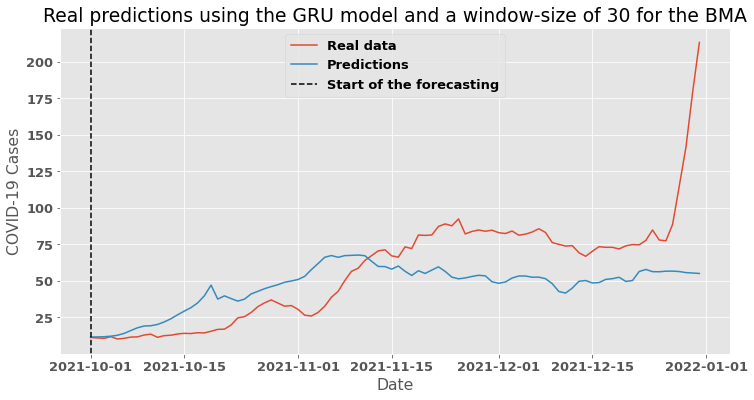

In [ ]:
plot_predicciones(testinverse,n_input,df_real_data)

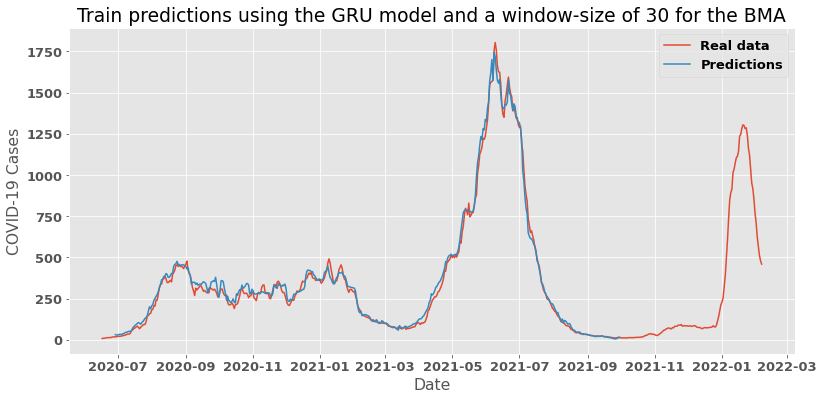

In [ ]:
plot_training(generator,model,X_scaler,n_input,train_MRNN_sc,df_real_data)

In [ ]:
# Infectados
testinverse.index = pd.to_datetime(testinverse.index, infer_datetime_format=True)
df_sim_m=testinverse.groupby([testinverse.index.strftime('%Y-%m')])['Predictions'].sum()

In [ ]:
df_sim_m

fecha_diagnostico
2021-10     933.063334
2021-11    1756.500799
2021-12    1606.116886
Name: Predictions, dtype: float64

# Datos Simulacion Residuos test otro periodo

In [ ]:
# Parámetros de entrada del script
periodo = '2' # Si es 1 la predicción empieza en julio 2021, si es 2 empieza en octubre 2021
modelo = 'LSTM'
window = '45'
capas = '1' # Si es 1 se usan muchas capas, si es 2 se usan menos capas en las redes neuronales

# Parámetros modelo
media=True # Aplicar filtro media móvil

# Fechas de predicción
if periodo=='1' or periodo=='':
    fechaITrain='2020-05-01'
    fechaFTrain='2021-06-30'
    fechaITest='2021-07-01'
    fechaFTest='2021-09-30'
elif periodo=='2':
    fechaITrain='2020-05-01'
    fechaFTrain='2021-12-31'
    fechaITest='2022-01-01'
    fechaFTest='2022-03-31'

In [ ]:
def preproceDatosAMB(ciudad):
    df=pd.read_csv("https://www.datos.gov.co/resource/gt2j-8ykr.csv?$limit=1000000&ciudad_municipio_nom="+ciudad)
    data = df.copy()
    data["fecha_diagnostico"] = data["fecha_diagnostico"].replace({'7/10/2020 0:00:01':'7/10/2020 0:00:00'}) # Corrección de incosistencia en el dataset
    data["fecha_diagnostico"] = pd.to_datetime(data["fecha_diagnostico"], infer_datetime_format=True)
    contagiados = data[data["fecha_diagnostico"].isna()!=True]
    contagiados = contagiados["fecha_diagnostico"].groupby(contagiados["fecha_diagnostico"]).count()
    contagiados = contagiados.sort_index()
    #contagiados = contagiados/pob_ciudades[pob_ciudades["Ciudad"]==ciudad]['Población'].values[0]
    contagiadosdf=pd.DataFrame(contagiados, columns= ['fecha_diagnostico'])
    contagiadosdf.index = pd.to_datetime(contagiadosdf.index, infer_datetime_format=True)
    return contagiadosdf

def generar_train_test_datasets(media, fechaITrain, fechaFTrain, fechaITest, fechaFTest):
    contagiadosBmanga=preproceDatosAMB('BUCARAMANGA')
    contagiadosFlorida=preproceDatosAMB('FLORIDABLANCA')
    contagiadosGiron=preproceDatosAMB('GIRON')
    contagiadosPiedecuesta=preproceDatosAMB('PIEDECUESTA')

    contagiadosAMB=contagiadosBmanga.copy()
    contagiadosAMB= contagiadosAMB.add(contagiadosFlorida, fill_value=0)
    contagiadosAMB=contagiadosAMB.add(contagiadosGiron, fill_value=0)
    contagiadosAMB=contagiadosAMB.add(contagiadosPiedecuesta, fill_value=0)

    data = contagiadosAMB.copy()

    # Media móvil
    if media:
            data=data.rolling(window=7).mean()
            data=data.dropna()

    #division del dataset en train y test
    df = pd.DataFrame(data)
    df.rename(columns = {'fecha_diagnostico':'cases'}, inplace = True)
    df_real_data = df.copy()
    df_train=df[fechaITrain:fechaFTrain]
    df_test=df[fechaITest:fechaFTest]

    X_scaler = MinMaxScaler(feature_range=(0,1))
    Y_scaler = MinMaxScaler(feature_range=(0,1))
    X_data=X_scaler.fit_transform(df_train)
    Y_data=Y_scaler.fit_transform(df_test)
    train_MRNN_sc=pd.DataFrame(X_data,index=df_train.index,columns=['cases'])
    test_MRNN_sc=pd.DataFrame(Y_data,index=df_test.index,columns=['cases'])

    test_MRNN_sc['cases'][:]=0    #Unicamente para asegurar que las predicciones no esten tomando los valores reales de BMW 

    return train_MRNN_sc, test_MRNN_sc, X_scaler, Y_scaler, df_real_data


def generador_serie_tiempo(train_MRNN_sc,test_MRNN_sc):
    train_MRNN_scN=train_MRNN_sc.to_numpy()
    test_MRNN_scN=test_MRNN_sc.to_numpy()
    n_input = int(window)
    n_features = 1
    generator = TimeseriesGenerator(train_MRNN_scN, train_MRNN_scN, length=n_input, batch_size=1)   
    return generator,n_input,n_features,train_MRNN_scN, test_MRNN_scN

def generar_predicciones(model,train_MRNN_scN,test_MRNN_scN,Y_scaler,n_input,n_features):
    test_predictions = []
    test_variables=test_MRNN_scN
    temporal=[]

    first_eval_batch = train_MRNN_scN[-n_input:]
    current_batch = first_eval_batch.reshape((1, n_input, n_features))
    test_batch= test_variables.reshape((1,len(test_variables),n_features))

    for i in range(len(test_MRNN_scN)):
        # get the prediction value for the first batch
        current_pred = model.predict(current_batch)[0]
    
        # append the prediction into the array
        test_predictions.append(current_pred[n_input-1,0])

        test_batch[0,i,0]=current_pred[n_input-1,0]
        #test_batch[0,i,0]=current_pred
        temporal= test_batch[0,i,:]
        temporal= temporal.reshape((1,1,1))
        # use the prediction to update the batch and remove the first value
        #current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
        current_batch = np.append(current_batch[:,1:,:],temporal,axis=1)
    
    true_predictions = Y_scaler.inverse_transform([test_predictions])
    Predicciones=[]

    for i in range(len(test_MRNN_scN)):
        Predicciones.append(true_predictions[0][i])

    return Predicciones

def plot_predicciones(testinverse,n_input,df_real_data):
    fig = plt.figure(figsize=(10, 6))
    df_real_data=df_real_data[fechaITest:fechaFTest]
    plt.plot(df_real_data.index,df_real_data['cases'], label="Real data")
    plt.plot(testinverse.index,testinverse['Predictions'],label="Predictions")

    if periodo=='1' or periodo=='':
        plt.axvline(x=datetime.date(2021, 7, 1), ymin=-1, ymax=2,color="black",linestyle = "dashed",label="Start of the forecasting")
    elif periodo=='2':
        plt.axvline(x=datetime.date(2021, 10, 1), ymin=-1, ymax=2,color="black",linestyle = "dashed",label="Start of the forecasting")

    plt.legend(loc='best')
    plt.title("Real predictions using the "+modelo + " model and a window-size of "+str(n_input)+ " for the AMB")
    plt.xlabel("Date")
    plt.ylabel("COVID-19 Cases")
    plt.show()

def plot_training(generator,model,Y_scaler,n_input,train_MRNN_sc,df_real_data):
    trainRNNM_predict  = model.predict(generator)
    trainRNNM_predict=trainRNNM_predict[:,n_input-1,0].reshape(-1,1)
    trainRNNM_predict = Y_scaler.inverse_transform(trainRNNM_predict)
    trainRNNM_predict=pd.DataFrame(trainRNNM_predict ,index=train_MRNN_sc.index[n_input:],columns=['Test'])
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(1, 1, 1)
    plt.plot(df_real_data[n_input:-120].index,df_real_data['cases'][n_input:-120], label="Real data")
    plt.plot(trainRNNM_predict.index,trainRNNM_predict['Test'],label="Predictions")
    plt.title("Train predictions using the "+modelo + " model and a window-size of "+str(n_input)+ " for the AMB")
    ax.set_xlabel('Date')
    plt.ylabel("COVID-19 Cases")
    ax.get_gid()
    ax.legend()
    plt.show()

## Generacion

In [ ]:
train_MRNN_sc, test_MRNN_sc, X_scaler, Y_scaler,df_real_data=generar_train_test_datasets(media, fechaITrain, fechaFTrain, fechaITest, fechaFTest)
generator,n_input,n_features,train_MRNN_scN, test_MRNN_scN=generador_serie_tiempo(train_MRNN_sc,test_MRNN_sc)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  app.launch_new_instance()


#### Cargar modelo y predecir

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Proyecto-Residuos-COVID-AMB/Resultados/ResultadosPRES/octubre-diciembre 2021/LSTM/model_ws_45_LSTM_cps_1-model.h5')

In [ ]:
Predicciones=generar_predicciones(model,train_MRNN_scN,test_MRNN_scN,Y_scaler,n_input,n_features)
testinverse=pd.DataFrame(Y_scaler.inverse_transform(test_MRNN_sc), index=test_MRNN_sc.index,columns=test_MRNN_sc.columns)
testinverse['Predictions']=Predicciones

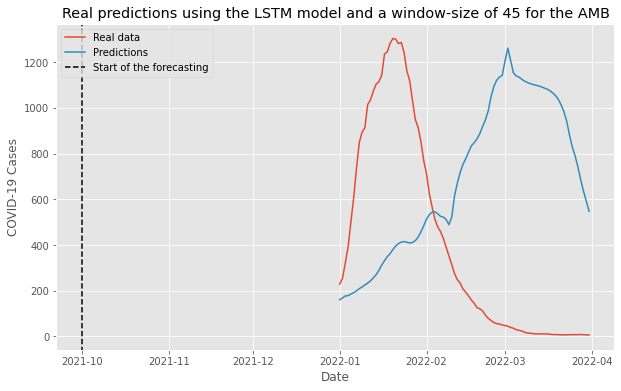

In [ ]:
plot_predicciones(testinverse,n_input,df_real_data)

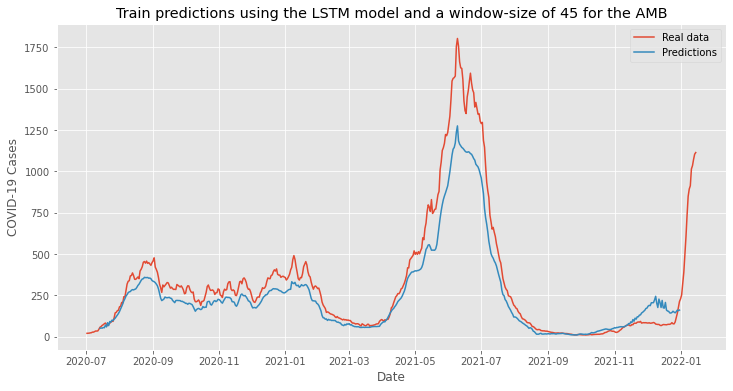

In [ ]:
plot_training(generator,model,Y_scaler,n_input,train_MRNN_sc,df_real_data)

In [ ]:
# Infectados
testinverse.index = pd.to_datetime(testinverse.index, infer_datetime_format=True)
df_sim_m=testinverse.groupby([testinverse.index.strftime('%Y-%m')])['Predictions'].sum()

In [ ]:
df_sim_m

fecha_diagnostico
2022-01     9593.563849
2022-02    21408.888881
2022-03    31000.471963
Name: Predictions, dtype: float64

# **Simulación de generación de residuos**


### **Datos usados para la simulación**

1. **Dataset del crecimiento poblacion para el AMB según proyecciones del DANE**

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/DavidGD03/plastics-COVID_project/main/data/crecimiento_poblacional.csv')

2. **Dataset del Banco Mundial sobre la composición de los desechos en Colombia**

In [ ]:
df2 = pd.read_csv('https://raw.githubusercontent.com/DavidGD03/plastics-COVID_project/main/data/tasa_residuos.csv')
df2_filtro = df2[df2["country_name"] == 'Colombia']
df2_filtro = df2_filtro.dropna(axis=1)

3. **Datos de toneladas totales y aprovechables en el AMB desde 2016 hasta 2021 según el SUI**

In [3]:
ton_aprov_mes = pd.read_excel('https://github.com/DavidGD03/plastics-COVID_project/blob/main/data/ton_aprov_mes%20_E.xlsx?raw=true')
#ton_tot_mes = pd.read_excel('https://github.com/DavidGD03/plastics-COVID_project/blob/main/data/ton_totales_mes%20_E.xlsx?raw=true')
ton_tot_mes = pd.read_excel('https://github.com/DavidGD03/plastics-COVID_project/blob/main/data/ton_totales_mes%20_EActu.xlsx?raw=true')
ton_aprov_mes=ton_aprov_mes.set_index(['MES'])
ton_tot_mes=ton_tot_mes.set_index(['MES'])

In [ ]:
ton_ac=[]
for i in range(12):
  ton_ac.append(ton_tot_mes.iloc[i].dropna().mean())

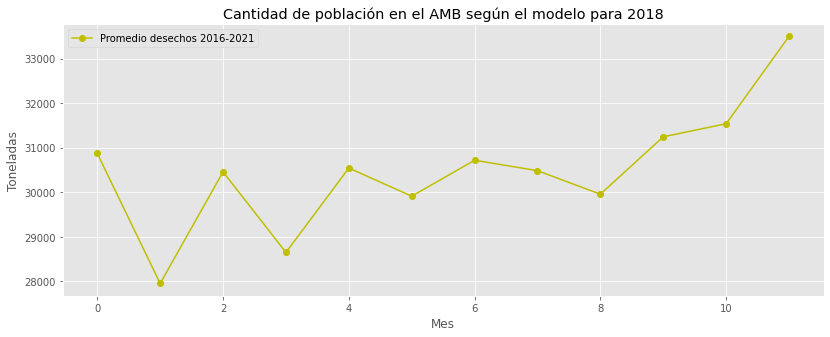

In [ ]:
fig = plt.figure(figsize=(30,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(ton_ac,label='Promedio desechos 2016-2021',marker='o',color='y');
ax.legend();
ax.set_xlabel('Mes');
ax.set_ylabel('Toneladas');
ax.title.set_text('Cantidad de población en el AMB según el modelo para 2018')
#ax.set_ylim(ymin=1170000,ymax=1200000)
plt.show()

Dataset actualizado:

In [ ]:
ton_tot_act = pd.read_excel('https://github.com/DavidGD03/plastics-COVID_project/blob/main/data/ton_simulacion_2021.xlsx?raw=true')

In [ ]:
options=['BUCARAMANGA','FLORIDABLANCA','GIRON','PIEDECUESTA']
ton_tot_bga=ton_tot_act[ton_tot_act["MUNICIPIO ORIGEN DE LOS RESIDUOS"].isin(options)]

In [ ]:
ton_tot_bga2=ton_tot_bga[['MES','TONELADAS DISPUESTAS']]

In [ ]:
dfact=pd.DataFrame(ton_tot_bga2.groupby(['MES'])['TONELADAS DISPUESTAS'].sum())

In [ ]:
dfact.reset_index(inplace=True)

### Datos reales AMB

In [4]:
#ton_tot_mes.index= (['JANUARY', 'FEBRUARY', 'MARCH', 'APRIL', 'MAY', 'JUNE', 'JULY', 'AUGUST', 'SEPTEMBER', 'OCTOBER', 'NOVEMBER', 'DECEMBER'])
ton_tot_mes.index= (['ENERO', 'FEBRERO', 'MARZO', 'ABRIL', 'MAYO', 'JUNIO', 'JULIO', 'AGOSTO', 'SEPTIEMBRE', 'OCTUBRE', 'NOVIEMBRE', 'DICIEMBRE'])

Text(0.5, 1.0, 'Toneladas totales de residuos generadas por mes en el AMB')

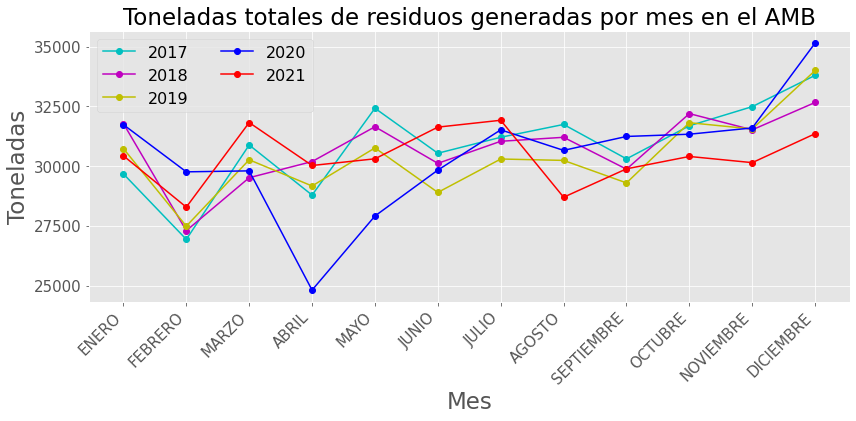

In [5]:
fig = plt.figure(figsize=(30,5))
ax = fig.add_subplot(1, 2, 1)


plt.rcParams['font.size'] = '24'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(15)
 

#ax.plot(ton_tot_mes[2016],label='2016',marker='o',color='b');
ax.plot(ton_tot_mes[2017],label='2017',marker='o',color='c');
ax.plot(ton_tot_mes[2018],label='2018',marker='o',color='m');
ax.plot(ton_tot_mes[2019],label='2019',marker='o',color='y');
ax.plot(ton_tot_mes[2020],label='2020',marker='o',color='b');
ax.plot(ton_tot_mes[2021],label='2021',marker='o',color='r');
#ax.legend(loc='upper left')
ax.legend(fontsize=16,ncol=2);
ax.set_xlabel('Mes',fontsize=23);
ax.set_ylabel('Toneladas',fontsize=23);
#plt.tight_layout()
plt.xticks(rotation=45, ha="right")
#plt.title('Total tons of waste generated per month in the study case',fontsize=23)
plt.title('Toneladas totales de residuos generadas por mes en el AMB',fontsize=23)
#plt.show()

Text(0.5, 1.0, 'Cantidad estimada de residuos de plástico basada en el total de residuos para el AMB')

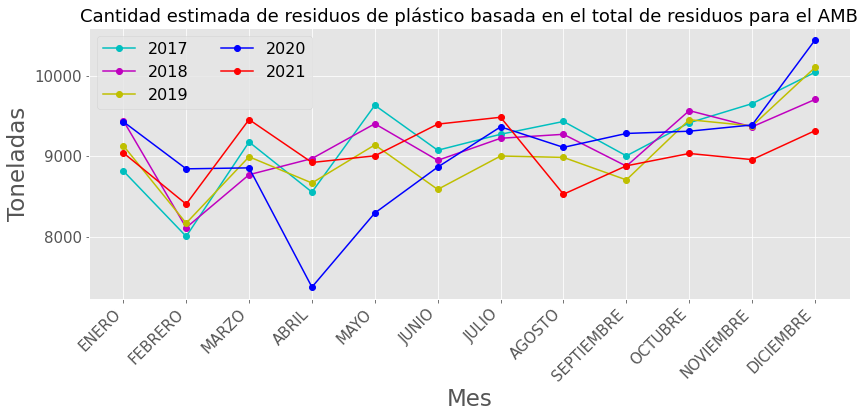

In [7]:
porcen_plasticS=0.2972 # porcentaje de plástico según informe sectorial aprovechamiento 2020 para Santander
ton_plastic_mes=ton_tot_mes*porcen_plasticS
fig = plt.figure(figsize=(30,5))

#plt.rcParams['font.size'] = '24'

 
ax = fig.add_subplot(1, 2, 1)

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(15)
 
#ax.plot(ton_tot_mes[2016],label='2016',marker='o',color='b');
ax.plot(ton_plastic_mes[2017],label='2017',marker='o',color='c');
ax.plot(ton_plastic_mes[2018],label='2018',marker='o',color='m');
ax.plot(ton_plastic_mes[2019],label='2019',marker='o',color='y');
ax.plot(ton_plastic_mes[2020],label='2020',marker='o',color='b');
ax.plot(ton_plastic_mes[2021],label='2021',marker='o',color='r');
ax.legend(loc='upper left')
ax.legend(fontsize=16,ncol=2);
ax.set_xlabel('Mes',fontsize=23);
ax.set_ylabel('Toneladas',fontsize=23);
plt.xticks(rotation=45, ha="right")
#ax.title.set_text('Estimated amount of plastic waste based on total waste and reported use of plastics')
plt.title('Cantidad estimada de residuos de plástico basada en el total de residuos para el AMB',fontsize=18)

### Definición de variables

**Variables:**

- Pop= cantidad total de habitantes en el AMB

- WGR= Tasa de generacion de residos per capita

- n= Año de la simulación

- pgr= Tasa de crecimiento poblacional obtenido de manera aleatoria
- wggr= Tasa de crecimiento de generación de residuos obtenido de manera aleatoria







In [ ]:
# Usaremos solo ciertos años del dataset de tasa crecimiento poblacional en el AMB
df3=df.iloc[:,11:15]
df3_T = df3.T
df3_p=(df3_T/100)/12
df3_p

,0
2016 [YR2016],0.001377
2017 [YR2017],0.001486
2018 [YR2018],0.001872
2019 [YR2019],0.002540


In [ ]:
pob_bga=['1177635','1204093','1240794','1270187']
df4=pd.DataFrame(pob_bga,columns=['POB'],index=['2017','2018','2019','2020'])

In [ ]:
dfton2=pd.DataFrame()
for i in range(len(df4)):
  dfton=ton_tot_mes[float(df4.index[i])]/float(df4['POB'].iloc[i])
  dfton2=pd.concat([dfton2,dfton])

In [ ]:
df_ton3=dfton2.pct_change()
df_ton4=df_ton3.fillna(df_ton3.mean())

### Enfoque Bayesiano en el Modelo

In [ ]:
df_ton_normal = np.concatenate((df_ton4.iloc[:9].values, df_ton4.iloc[12:21].values), axis=0)
df_ton_normal= np.concatenate((df_ton_normal, df_ton4.iloc[24:33].values), axis=0)
df_ton_normal= np.concatenate((df_ton_normal, df_ton4.iloc[36:45].values), axis=0)
df_ton_alto= np.concatenate((df_ton4.iloc[10:13].values, df_ton4.iloc[21:24].values), axis=0)
df_ton_alto= np.concatenate((df_ton_alto, df_ton4.iloc[33:36].values), axis=0)
df_ton_alto= np.concatenate((df_ton_alto, df_ton4.iloc[45:48].values), axis=0)

In [ ]:
df_ton_normal=pd.DataFrame(df_ton_normal,columns=['Tons'])
df_ton_alto=pd.DataFrame(df_ton_alto,columns=['Tons'])

In [ ]:
# Get the frequency, PDF and CDF for each value in the series

# Frequency
stats_df = df_ton_normal \
.groupby('Tons') \
['Tons'] \
.agg('count') \
.pipe(pd.DataFrame) \
.rename(columns = {'Tons': 'frequency'})

# PDF
stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])

# CDF
stats_df['cdf'] = stats_df['pdf'].cumsum()
stats_df = stats_df.reset_index()

In [ ]:
# Get the frequency, PDF and CDF for each value in the series

# Frequency
stats_df2 = df_ton_alto \
.groupby('Tons') \
['Tons'] \
.agg('count') \
.pipe(pd.DataFrame) \
.rename(columns = {'Tons': 'frequency'})

# PDF
stats_df2['pdf'] = stats_df2['frequency'] / sum(stats_df2['frequency'])

# CDF
stats_df2['cdf'] = stats_df2['pdf'].cumsum()
stats_df2 = stats_df2.reset_index()

### Parámetros del modelo

In [ ]:
PopInitial=1270187 # DANE - población AMB en 2020
porcen_plasticS=0.2972 # porcentaje de plástico según informe sectorial aprovechamiento 2020 para Santander
porcen_plasticI=0.4 # porcentaje plástico gente enferma
WGRInitial=0.033 # tasa de crecimiento de residuos diciembre 2019
porcen_I=0.8
porcen_S=1.025
meses=3
iter=10

### **Generación de datos**

In [ ]:
pred_pop100sd,pred_wgr100sd,pred_WQ100sd,pred_pgr100sd,pred_WQplastic100sd,pred_WQs100sd, pred_WQsp100sd=[],[],[],[],[],[],[]
pred_pop100=np.zeros((meses, 1))
pred_wgr100=np.zeros((meses, 1))
pred_pgr100=np.zeros((meses, 1))
pred_WQ100=np.zeros((meses, 1))
pred_WQplastic100=np.zeros((meses, 1))
pred_WQs100=np.zeros((meses, 1))
pred_WQsp100=np.zeros((meses, 1))

# Generamos las predicciones
for i in range(iter):
  pred_pop2,pred_wgr2,pred_WQ2,pred_pgr2,pred_WQpl2,predWQs2,predWQsp2=[],[],[],[],[],[],[]
  pred_pop2,pred_wgr2,pred_WQ2,pred_pgr2,pred_WQpl2,predWQs2,predWQsp2=sim_generacion(meses,2,PopInitial,porcen_plasticS,porcen_plasticI,WGRInitial,porcen_I,porcen_S,df3_p,stats_df,stats_df2,df_sim_m)

  pred_pop100sd.append(pred_pop2)
  pred_wgr100sd.append(pred_wgr2)
  pred_pgr100sd.append(pred_pgr2)
  pred_WQ100sd.append(pred_WQ2)
  pred_WQplastic100sd.append(pred_WQpl2)
  pred_WQs100sd.append(predWQs2)
  pred_WQsp100sd.append(predWQsp2)
  
  pred_pop100=np.add(pred_pop100, pred_pop2)
  pred_wgr100=pred_wgr100+pred_wgr2
  pred_pgr100=np.add(pred_pgr100, pred_pgr2)
  pred_WQ100=np.add(pred_WQ100, pred_WQ2) 
  pred_WQplastic100=np.add(pred_WQplastic100, pred_WQpl2) 
  pred_WQs100=np.add(pred_WQs100, predWQs2) 
  pred_WQsp100=np.add(pred_WQsp100, predWQsp2) 

pred_pop100=pred_pop100/iter
pred_wgr100=pred_wgr100/iter
pred_pgr100=pred_pgr100/iter
pred_WQ100=pred_WQ100/iter
pred_WQplastic100=pred_WQplastic100/iter
pred_WQs100=pred_WQs100/iter
pred_WQsp100=pred_WQsp100/iter


indice=['OCTOBER','NOVEMBER','DECEMBER']
  #población
pred_pop_df=pd.DataFrame(pred_pop100,columns =['2021'],index=indice)
  #tasa crecimiento poblacional
pred_pgr_df=pd.DataFrame(pred_pgr100,columns =['2021'],index=indice) 
  #tasa residuos per cápita
  #pred_wgr_df=pd.DataFrame(pred_wgr100,columns =['2020'],index=['ENERO','FEBRERO','MARZO','ABRIL','MAYO','JUNIO','JULIO','AGOSTO','SEPTIEMBRE','OCTUBRE','NOVIEMBRE','DICIEMBRE']) 
  #desechos totales
pred_wq_df=pd.DataFrame(pred_WQ100,columns =['2021'],index=indice) 

  #desechos plásticos
pred_wqp_df=pd.DataFrame(pred_WQplastic100,columns =['2021'],index=indice) 

pred_wqs_df=pd.DataFrame(pred_WQs100,columns =['2021'],index=indice) 

pred_wqsp_df=pd.DataFrame(pred_WQsp100,columns =['2021'],index=indice) 


# Desviación estándar
def sd_modelo(pred_sd):
  sd2=[]
  df_sd=pd.DataFrame(pred_sd)
  for i in range(meses):
    sd2v=np.std(df_sd[i])
    sd2.append(sd2v)
  return sd2

std_pop=sd_modelo(pred_pop100sd)
std_wgr=sd_modelo(pred_wgr100sd)
std_wq=sd_modelo(pred_WQ100sd)
std_pgr=sd_modelo(pred_pgr100sd)
std_wqp=sd_modelo(pred_WQplastic100sd)
std_wqs=sd_modelo(pred_WQs100sd)
std_wqsp=sd_modelo(pred_WQsp100sd)

### **Resultados del Modelo**

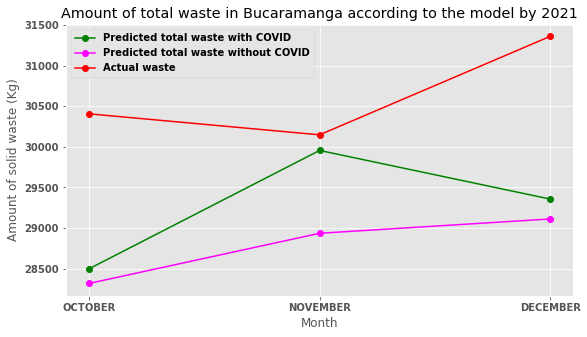

In [ ]:
plot_resultsT(pred_wq_df,pred_wqs_df,ton_tot_mes,0,std_wq,std_wqs)

In [ ]:
import matplotlib.pyplot as plt

# Plotear resultados de residuos totales
def plot_resultsT(predictedC,predictedNC,real,std,std_wq=0,std_wqs=0):
	fig = plt.figure(figsize=(20,5))
	ax = fig.add_subplot(1, 2, 1)
	if (std==1):
		ax.errorbar(predictedC.index,predictedC['2021'],yerr=std_wq,label='Predicted total waste with COVID',capthick=2,capsize=5,ecolor="green", marker='o' ,color='green');
		ax.errorbar(predictedNC.index,predictedNC['2021'],yerr=std_wqs,label='Predicted total waste without COVID',capthick=2,capsize=5,ecolor="magenta", marker='o' ,color='magenta');
	else:
		ax.plot(predictedC['2021'],label='Predicted total waste with COVID',marker='o',color='green');
		ax.plot(predictedNC['2021'],label='Predicted total waste without COVID',marker='o',color='magenta');
	ax.plot(real[2021][-3:],label='Actual waste',marker='o',color='red');
	ax.legend();
	ax.set_xlabel('Month');
	ax.set_ylabel('Amount of solid waste (Kg)');
	ax.title.set_text('Amount of total waste in Bucaramanga according to the model by 2021')
	plt.show()

#Plotear resultados de residuos plásticos
def plot_resultsP(predictedC,predictedNC,real,std,std_wq=0,std_wqs=0):
	fig = plt.figure(figsize=(20,5))
	ax = fig.add_subplot(1, 2, 1)
	if (std==1):
		ax.errorbar(predictedC.index,predictedC['2021'],yerr=std_wq,label='Predicted plastic waste with COVID',capthick=2,capsize=5,ecolor="green", marker='o' ,color='green');
		ax.errorbar(predictedNC.index,predictedNC['2021'],yerr=std_wqs,label='Predicted plastic waste without COVID',capthick=2,capsize=5,ecolor="magenta", marker='o' ,color='magenta');
	else:
		ax.plot(predictedC['2021'],label='Predicted plastic waste with COVID',marker='o',color='green');
		ax.plot(predictedNC['2021'],label='Predicted plastic waste without COVID',marker='o',color='magenta');
	ax.plot(real[2021][-3:],label='Estimated plastic waste',marker='o',color='red');
	ax.legend();
	ax.set_xlabel('Month');
	ax.set_ylabel('Amount of plastic waste (Kg)');
	ax.title.set_text('Amount of plastic waste in Bucaramanga as modeled for 2021')
	plt.show()

In [ ]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 10}

plt.rc('font', **font)

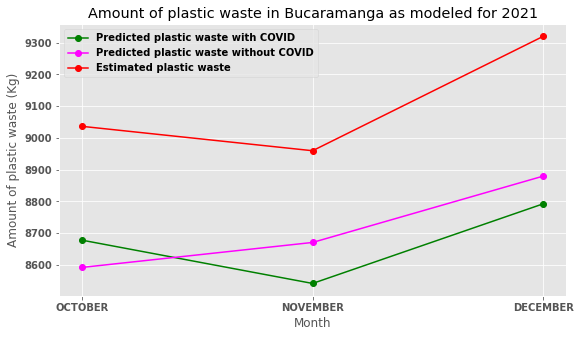

In [ ]:
plot_resultsP(pred_wqp_df,pred_wqsp_df,ton_plastic_mes,0,std_wqp,std_wqsp)

In [ ]:
abs(ton_plastic_mes[2021].iloc[-3:] - pred_wqsp_df['2021']).mean()

549.7130199461317

In [ ]:
ton_plastic_mes[2021].mean()

9038.121213666667

In [ ]:
df_abs = abs(ton_tot_mes[2021].iloc[-3:] - pred_wq_df['2021'])
df_abs.mean()

1368.016456680655

In [ ]:
df_abs2 = abs(ton_tot_mes[2021].iloc[-3:] - pred_wqs_df['2021'])
df_abs2

OCTOBER     1756.204042
NOVEMBER     196.443092
DECEMBER    2665.440131
dtype: float64

In [ ]:
# Comportamiento prediccion para las iteraciones
import random
fig = plt.figure(figsize=(30,5))
ax = fig.add_subplot(1, 2, 1)
iter=5
for i in range(iter):
  r = random.random()
  b = random.random()
  g = random.random()
  color = (r, g, b)
  #label='Iteración',i+1
  ax.plot(pred_WQ100sd[i],marker='o',color='blue');
  #ax.plot(pred_WQs100sd[i],marker='o',color='red');
ax.legend();
ax.set_xlabel('Mes');
ax.set_ylabel('Toneladas');
ax.title.set_text('Comparación desechos totales reales vs predichos para 2018')
#ax.set_ylim(ymin=0,ymax=40000)

In [ ]:
# Comportamiento poblacion
fig = plt.figure(figsize=(30,5))
ax = fig.add_subplot(1, 2, 1)
ax.errorbar(pred_pop_df.index,pred_pop_df['2021'],yerr=std_pop,label='Población AMB 2018',capthick=2,capsize=5,ecolor="Black", marker='o' ,color='y');
#ax.plot(pred_pop_df,label='Población AMB 2018',marker='o' ,color='y');
ax.legend();
ax.set_xlabel('Mes');
ax.set_ylabel('Cantidad de personas AMB');
ax.title.set_text('Cantidad de población en el AMB según el modelo para 2018')
#ax.set_ylim(ymin=1170000,ymax=1200000)
plt.show()

In [ ]:
# Comportamiento tasa de crecimiento poblacional
#fig = plt.figure(figsize=(30,5))
#ax = fig.add_subplot(1, 2, 1)
#ax.errorbar(pred_pgr_df.index,pred_pgr_df['2020'],yerr=std_pgr,label='Tasa de crecimiento poblacional AMB 2018',capthick=2,capsize=5,ecolor="Black", marker='o' ,color='y');
#ax.legend();
#ax.set_xlabel('Mes');
#ax.set_ylabel('Tasa de crecimiento');
#ax.title.set_text('Tasa de crecimiento de población en el AMB según el modelo para 2018')
#ax.set_ylim(ymin=1170000,ymax=1200000)
#plt.show()

In [ ]:
# Comportamiento tasa residuos
#fig = plt.figure(figsize=(30,5))
#ax = fig.add_subplot(1, 2, 1)
#ax.errorbar(pred_wgr_df.index,pred_wgr_df['2020'],yerr=std_wgr,label='Tasa de residuos AMB 2018',capthick=2,capsize=5,ecolor="Black", marker='o' ,color='y');
#ax.legend();
#ax.set_xlabel('Mes');
#ax.set_ylabel('Tasa de residuos per cápita');
#ax.title.set_text('Tasa de residuos per cápita según el modelo para 2018')
#ax.set_ylim(ymin=0,ymax=0.04)